<a href="https://colab.research.google.com/github/jkorgu/C4145CW/blob/main/CE4145cw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __Section One - Dataset__

By Jakub Olbrisch - Student Number: 2106944

## __Dataset Information__

The dataset is called "rotten_tomatoes", acquired from [Hugging Face](https://huggingface.co/datasets/cornell-movie-review-data/rotten_tomatoes)

The dataset itself is a collection of 10,662 rotten tomatoes movie reviews, split into 2 categories of positive and negative, labeled 1 and 0 respectively.

Furthermore, the dataset splits into "train", "validation" and "test" files which I will manually undo and redo to only 2 splits.

## __Task to be performed__

The task performed in this coursework is text classification with the main goal being able to predict the appropriate label as output through the content of the text within the review as input.

In [ ]:
#possible layouts
#1 dataset
#1.1 dataset exploration
#1.1.1 basic data exploration (shape, head, missing values) DONE
#1.1.2 class distribution (label per split, 3 bar graphs to confirm what was said earlier about dataset) DONEs
#1.2 preprocessing - merge validation and test before preproc proper DONE
#2 representation learning DONE
#3 algorithms DONE
#4 evaluation
#4.1 result interpretation?

## 1.1 Dataset Exploration

Here we will be exploring the dataset to confirm its shape, size and other factors to ensure it matches the description given online.

### 1.1.1 Basic Data Exploration

We will look at these parts of the dataset:
- Shape
- Sample of data
- Check for missing values

In [ ]:
#importing some basics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#import dataset from huggingface, splits are already decided on the website, as seen below with our seperate dataframes
splits = {'train': 'train.parquet', 'validation': 'validation.parquet', 'test': 'test.parquet'}
dfTrain = pd.read_parquet("hf://datasets/cornell-movie-review-data/rotten_tomatoes/" + splits["train"])
dfValidation = pd.read_parquet("hf://datasets/cornell-movie-review-data/rotten_tomatoes/" + splits["validation"])
dfTest = pd.read_parquet("hf://datasets/cornell-movie-review-data/rotten_tomatoes/" + splits["test"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
#Shape of the training dataset
print(f'dfTrain has {dfTrain.shape[0]} rows, and {dfTrain.shape[1]} columns')
print(f'dfValidation has {dfValidation.shape[0]} rows, and {dfValidation.shape[1]} columns')
print(f'dfTest has {dfTest.shape[0]} rows, and {dfTest.shape[1]} columns')
print(f'Total rows of the entire dataset: {dfTrain.shape[0]+dfValidation.shape[0]+dfTest.shape[0]}')

dfTrain has 8530 rows, and 2 columns
dfValidation has 1066 rows, and 2 columns
dfTest has 1066 rows, and 2 columns
Total rows of the entire dataset: 10662


In [ ]:
#Missing valuees check - should have none
print(f'dfTrain missing values:\n{dfTrain.isnull().sum()}')
print(f'dfValidation missing values:\n{dfValidation.isnull().sum()}')
print(f'dfTest missing values:\n{dfTest.isnull().sum()}')

dfTrain missing values:
text     0
label    0
dtype: int64
dfValidation missing values:
text     0
label    0
dtype: int64
dfTest missing values:
text     0
label    0
dtype: int64


In [ ]:
#Show the training data, both positive and negative entries (confirming text and label columns too)
dfTrain.head(-5)

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1
...,...,...
8520,"the star who helped give a spark to "" chasing ...",0
8521,a summary of the plot doesn't quite do justice...,0
8522,every conceivable mistake a director could mak...,0
8523,"snoots will no doubt rally to its cause , trot...",0


### 1.1.2 Class Distribution

Confirming through plots an even class distribution

<Axes: title={'center': 'dfTest positive/negative review split'}, xlabel='label', ylabel='count'>

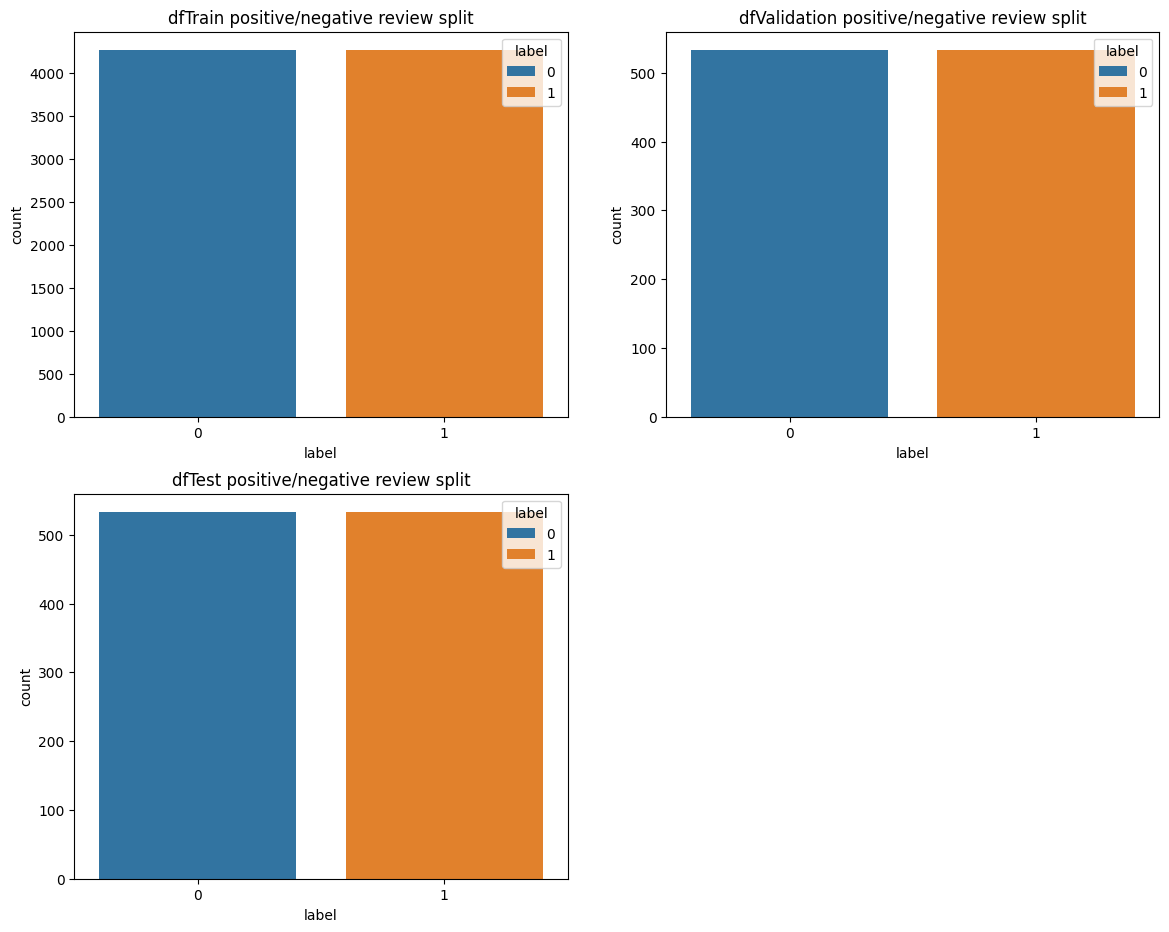

In [ ]:
#make 3 subplots - one for each data-split
plt.figure(figsize=(14,11))
#First subplot                  - dfTrain
plt.subplot(2,2,1)
plt.title('dfTrain positive/negative review split')
sns.countplot(x='label', data=dfTrain, hue='label')
#Second subplot                 - dfValidation
plt.subplot(2,2,2)
plt.title('dfValidation positive/negative review split')
sns.countplot(x='label', data=dfValidation, hue='label')
#Third subplot                  - dfTest
plt.subplot(2,2,3)
plt.title('dfTest positive/negative review split')
sns.countplot(x='label', data=dfTest, hue='label')

## 1.2 Preprocessing

In [ ]:
#merged everything
dfMerged = [dfTrain, dfValidation, dfTest]
dfFull = pd.concat(dfMerged)
dfFull.shape

(10662, 2)

label
1    5331
0    5331
Name: count, dtype: int64


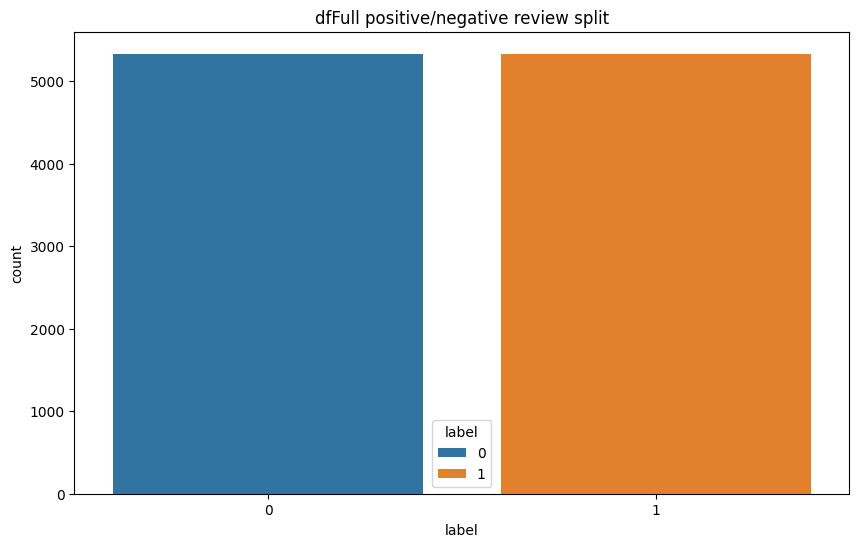

In [ ]:
#plot new dataframe to ensure even label split (text value added too for 100% accuracy)
plt.figure(figsize=(10,6))
plt.title('dfFull positive/negative review split')
sns.countplot(data=dfFull, x='label', hue='label')
print(dfFull['label'].value_counts())

In [ ]:
#Converting into numpy arrays
x = dfFull['text'].to_numpy()
y = dfFull['label'].to_numpy()
#test
#print(x)
#print(y)

For pre-processing I chose to use tokenisation alongside a lemmatizer, from testing I found that stemming took away too much, whilst a lemmatizer kept a better output.

Whilst also keeping the reviews as tokens instead of strings.

In [ ]:
#import nltk functionalities alongside sklearn functionalities
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def prep(X):
    prepText = []
    for x in X:
      tokenText = word_tokenize(x) #tokenize data
      normdText = [token.lower() for token in tokenText] #simple cleaning by lowercase casting

      swrd = stopwords.words('english') #stopwords is saved as an object
      swrdText = [token for token in normdText if token not in swrd]

      lemm = WordNetLemmatizer() #lemmatize - want to keep full meaning of words
      #GloVe needs tokens instead of strings hence the lack of joining the sentences back up together
      prepText += [[lemm.lemmatize(word) for word in swrdText]]
    return prepText

#processed data
procx = prep(x)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
#token layout
print(procx[0])

['rock', 'destined', '21st', 'century', "'s", 'new', '``', 'conan', '``', "'s", 'going', 'make', 'splash', 'even', 'greater', 'arnold', 'schwarzenegger', ',', 'jean-claud', 'van', 'damme', 'steven', 'segal', '.']


#__Section Two - Representation Learning__

GloVe was intended for unsupervised learning of word representations.

The primary objective of GloVe is to capture semantic relationships between words through seeing how frequently words appear together in a dataset.

That allows for it to understand nuanced movie reviews, which may reference terms/topics uncommonly seen linked together in everyday life.

Distinguishing this has prioritised GloVe implementation over any other mode of representation learning for me.

<br>

Below I load a pretrained GloVe model and setup a function to convert a sentence into a GloVe embedded one.


In [ ]:
#this takes anywhere from 2 to 5minutes
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-12-03 03:29:58--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  4.37MB/s    in 3m 54s  

2025-12-03 03:33:53 (3.51 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
#load pretrained glove model
def loadGlove(path="glove.6B.300d.txt"):
  embeddings = {}
  with open(path, 'r', encoding='utf8') as gloveFile:
    for line in gloveFile:
      parts = line.strip().split()
      word = parts[0]
      vector = np.array(parts[1:], dtype='float32')
      embeddings[word] = vector
  return embeddings

glove = loadGlove('glove.6B.300d.txt')

#convert the sentence into a glove embedded one
def gloveRep(sentence, glove_dict, emb_size=300):
  embs = [glove_dict[word] for word in sentence if word in glove_dict]
  sentEmb = np.mean(np.array(embs), axis=0)
  return sentEmb

#__Section Three - Algorithms__

###Algorithm 1: Logistic Regression

Logistic Regression is an algorithm used for classification problems.

Logistic Regression works through its use of a sigmoid function to convert inputs into probability values in the range of 0-1.

The model learns weight and bias which determines where classes lay on the positive-to-negative scale, by maximizing the likelihood of the training data.

With the use of GloVe embeddings Logistic Regression works well as there are dense numeric features available thus creating good compatibility with algorithm and data.

<br>

###Algorithm 2: Random Forest

Random Forest is an algorithm that creates many decision trees which individually look at parts of the data in a random sequence and the results are gathered by a voting system between the trees.

Classification is decided through the voting system outcome, through the use of seperate trees taking random data to learn, it helps to avoid overfitting which usually gives quite accurate results back.

Random Forest works best with huge non-linear datasets consisting of many features, which is not what I have here, but that is the reason this algorithm was chosen as it allows me to benchmark against linear algorithms.

<br>

###Algorithm 3: Support Vector Machine (SVM)

SVM is a supervised algorithm used for classification and regression, it attempts to find the best hyperplane to seperate data into groups, which it then attempts to maximise the margin between the two seperated classes.
Higher margins make the model perform better on unseen data.

SVM is known for being a strong algorithm for classification tasks like the one I am undertaking, and as a slightly more complex concept than something like Logistic Regression it stands out as a solid option for my project here, as now I cover a rather "simple" algorithm in Logistic Regression, a benchmark algorithm that is not predicted to be as strong here in Random Forest and a slightly more complex algorithm that is well suited for this task in SVM.

In [ ]:
#this takes anywhere from 4 to 6 minutes
#import all necessities
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#setup for score tracking
lrAccScore = []
lrF1Score = []
lrPrecScore= []

rfAccScore = []
rfF1Score = []
rfPrecScore = []

svmAccScore = []
svmF1Score = []
svmPrecScore = []

#splits
x_train, x_test, y_train, y_test = train_test_split(procx, y, test_size=0.2, stratify=y, random_state=1337)

#convert sentences using glove
x_trainGlove = [gloveRep(sentence, glove) for  sentence in x_train]
x_testGlove = [gloveRep(sentence, glove) for sentence in x_test]


#LOGISTIC REGRESSION ALGORITHM
lr = LogisticRegression(max_iter=500)
lrParams = {'C': [0.1, 1, 10]}
lrGrid = GridSearchCV(lr, lrParams, cv=5, scoring="accuracy")
lrGrid.fit(x_trainGlove, y_train)
lrPred = lrGrid.predict(x_testGlove)

#accuracy/score/precision
lrAcc = accuracy_score(lrPred, y_test)
lrF1 = f1_score(lrPred, y_test)
lrPrec = precision_score(lrPred, y_test)

#accuracy/score/precision appended
lrAccScore.append(lrAcc)
lrF1Score.append(lrF1)
lrPrecScore.append(lrPrec)



#RANDOM FOREST ALGORITHM
rf = RandomForestClassifier(max_depth=3)
rfParams = {'n_estimators': [100,200,300]}
rfGrid = GridSearchCV(rf, rfParams, cv=5, scoring="accuracy")
rfGrid.fit(x_trainGlove, y_train)
rfPred = rfGrid.predict(x_testGlove)

#accuracy/score/precision
rfAcc = accuracy_score(rfPred, y_test)
rfF1 = f1_score(rfPred, y_test)
rfPrec = precision_score(rfPred, y_test)

#accuracy/score/precision appended
rfAccScore.append(rfAcc)
rfF1Score.append(rfF1)
rfPrecScore.append(rfPrec)



#SVM ALGORITHM
svm = SVC(kernel='linear')
svmParams = {'C': [0.1, 1, 10]}
svmGrid = GridSearchCV(svm, svmParams, cv=5, scoring="accuracy")
svmGrid.fit(x_trainGlove, y_train)
svmPred = svmGrid.predict(x_testGlove)

#accuracy/score/precision
svmAcc = accuracy_score(svmPred, y_test)
svmF1 = f1_score(svmPred, y_test)
svmPrec = precision_score(svmPred, y_test)

#accuracy/score/precision appended
svmAccScore.append(svmAcc)
svmF1Score.append(svmF1)
svmPrecScore.append(svmPrec)


#final scores
print("Logistic Regression Score:\nAccuracy:", np.mean(lrAccScore),"\nF1 Score:", np.mean(lrF1Score),"\nPrecision:", np.mean(lrPrecScore))
print("Random Forest Score:\nAccuracy:", np.mean(rfAccScore),"\nF1 Score:", np.mean(rfF1Score),"\nPrecision:", np.mean(rfPrecScore))
print("SVM Score:\nAccuracy:", np.mean(svmAccScore),"\nF1 Score:", np.mean(svmF1Score),"\nPrecision:", np.mean(svmPrecScore))

Logistic Regression Score:
Accuracy: 0.7529301453352086 
F1 Score: 0.7533926064576509 
Precision: 0.7544517338331771
Random Forest Score:
Accuracy: 0.6943272386310361 
F1 Score: 0.6874400767018217 
Precision: 0.6719775070290535
SVM Score:
Accuracy: 0.7590248476324426 
F1 Score: 0.7573182247403211 
Precision: 0.7516401124648547


#Section Four - Evaluation

Here we will investigate and interpret the results through visualisation techniques

In [ ]:
#store models for easier visualisation
models = ["lr", "RF", "SVM"]
modelAcc = [np.mean(lrAccScore), np.mean(rfAccScore), np.mean(svmAccScore)]
modelF1  = [np.mean(lrF1Score),  np.mean(rfF1Score),  np.mean(svmF1Score)]
modelPrec = [np.mean(lrPrecScore), np.mean(rfPrecScore), np.mean(svmPrecScore)]

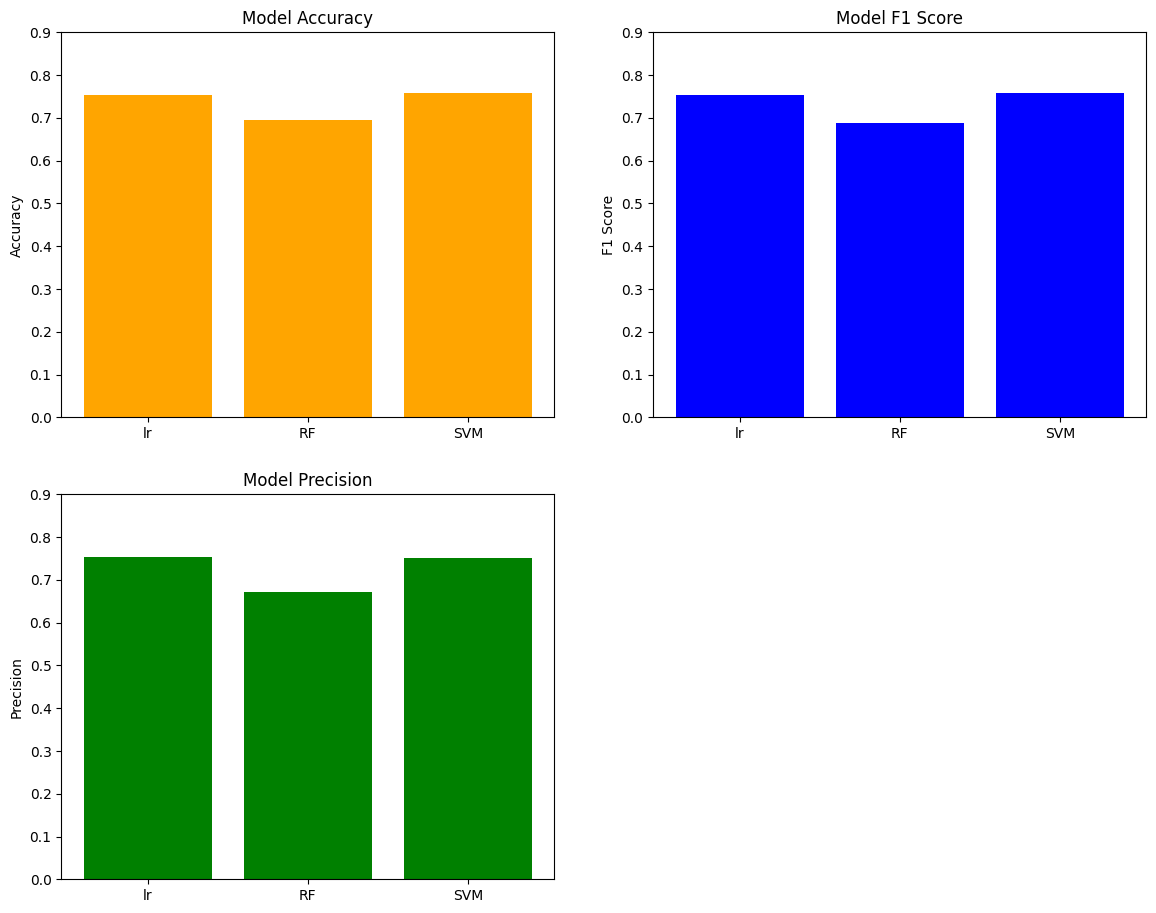

In [ ]:
#make 3 subplots - one for each performance metric
#ylim at 0.9 makes the graph a bit nicer
plt.figure(figsize=(14, 11))
#First subplot                  - ACCURACY
plt.subplot(2, 2, 1)
plt.title("Model Accuracy")
plt.bar(models, modelAcc, color="orange")
plt.ylim(0, 0.9)
plt.ylabel("Accuracy")
#Second subplot                 - F1 SCORE
plt.subplot(2, 2, 2)
plt.title("Model F1 Score")
plt.bar(models, modelF1, color="blue")
plt.ylim(0, 0.9)
plt.ylabel("F1 Score")
#Third subplot                  - PRECISION
plt.subplot(2, 2, 3)
plt.title("Model Precision")
plt.bar(models, modelPrec, color="green")
plt.ylim(0, 0.9)
plt.ylabel("Precision")
plt.show()

As we can see from the graphs above and the numerical values from the algorithms, Logistic Regression and SVM perform very similarly in every single metric, whilst Random Forest falls off a bit in every aspect, but especially in Precision.

This conclusion was partially expected when choosing the algorithms, with Random Forest performing worse, however, the performance of Logistic Regression and SVM being near identical is quite a surprise, and it just shows with the correct pre-processing on smaller tasks you can use simpler algorithms for similar results to more complex algorithms.

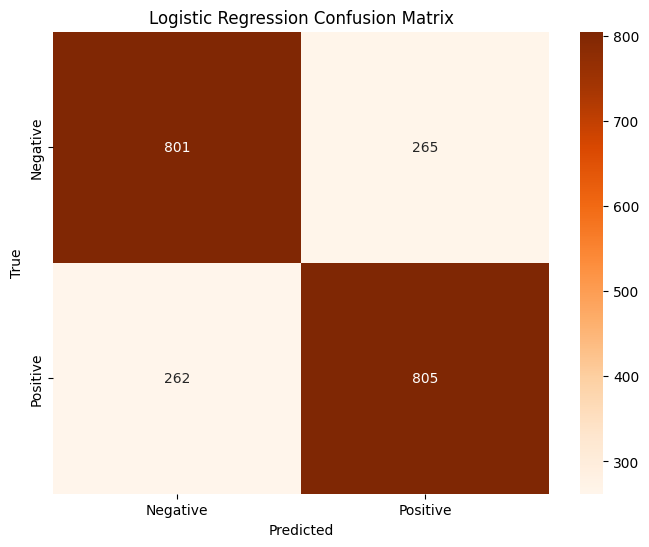

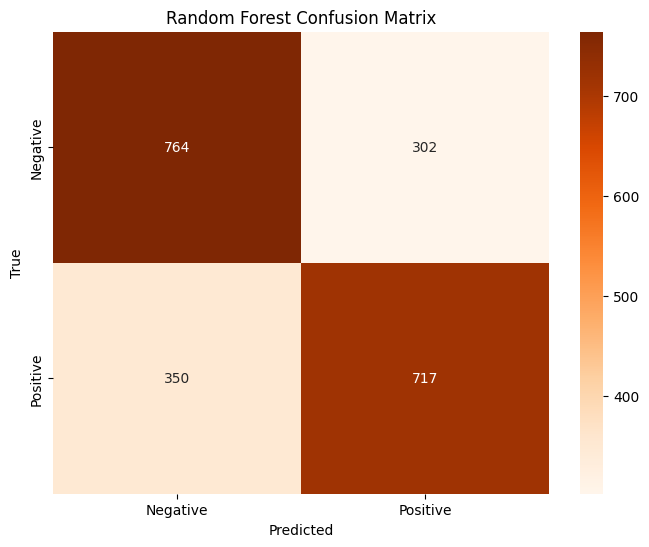

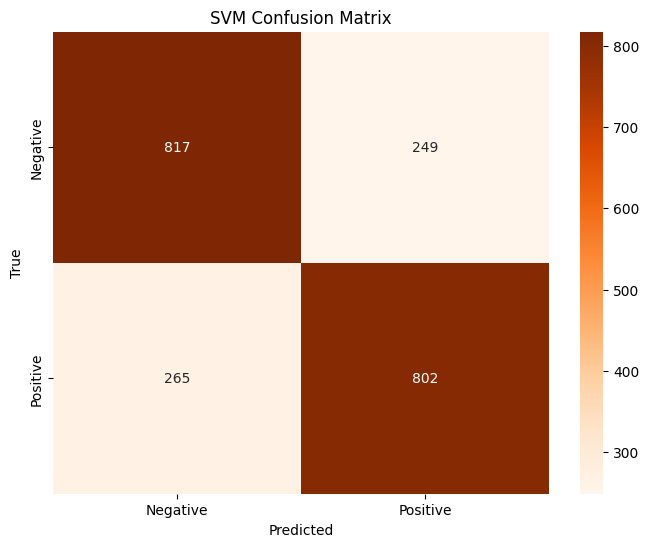

In [ ]:
#Confusion Matrix plots
from sklearn.metrics import confusion_matrix
#LOGISTIC REGRESSION
lrCM = confusion_matrix(y_test, lrPred)
#plot
plt.figure(figsize=(8,6))
sns.heatmap(lrCM, annot=True, fmt="d", cmap="Oranges", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#RANDOM FOREST
rfCM = confusion_matrix(y_test, rfPred)
#plot
plt.figure(figsize=(8,6))
sns.heatmap(rfCM, annot=True, fmt="d", cmap="Oranges", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#SVM
svmCM = confusion_matrix(y_test, svmPred)
#plot
plt.figure(figsize=(8,6))
sns.heatmap(svmCM, annot=True, fmt="d", cmap="Oranges", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Continuing the analysis with the above confusion matrix,

We can see that SVM performs the best in capturing both positives with negatives over both Logistic Regression and Random Forest, however, every single model performs well with classifying between positive and negative reviews.

This suggests that SVM is the most suitable for this task (although by minimal amounts) and in future testing, altering more hyperparameters of SVM may produce better results.

Additionally other representation learning techniques, such as TF-IDF may be worth testing to see if results improve.